## Pytorch sur des séquences de texte

#### Import des librairies

In [1]:
import torchtext
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, TabularDataset, BucketIterator

#### Tokenization

In [2]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### Definition des Prétraitements sur le texte

In [3]:
TEXT = Field(sequential = True, lower=True, include_lengths = False,
                  pad_token = "<pad>", unk_token = "<unk>",
                  batch_first = True, tokenize = tokenizer)

LABELS = Field(sequential=False, use_vocab=False)

#### Création des datasets

In [4]:
train_dataset, test_dataset = TabularDataset.splits(
    path='./data', format='tsv',
    train='sentiment-train', test='sentiment-test',
    fields=[('text', TEXT), ('labels', LABELS)])

#### Gestion des batchs

In [5]:
device = torch.device('cuda')

train_iter, test_iter = BucketIterator.splits(
    (train_dataset,  test_dataset), batch_sizes=(16, 256),
    sort_key = lambda x: len(x.text), device=device, 
    sort_within_batch = True, shuffle = True, repeat=False)

#### Gestion du vocabulaire et des word Embeddings

In [6]:
TEXT.build_vocab(train_dataset, min_freq=2, vectors = 'glove.6B.50d')
print("Size vocab :", len(TEXT.vocab))

Size vocab : 13246


In [7]:
#TEXT.vocab.stoi

#### Visualisation d'un batch de données

In [8]:
batch = next(iter(train_iter))

In [9]:
batch.text

tensor([[   22,   199,   304,    66,  1649,     2,  1633,   120,    70,  8804,
            69,    23,   194,   196,  6275,   836,    13,     8],
        [   92,    22,   182,    44,   850,    11,     4,   886,    35,    95,
             7,    40,  4547,     3,    26,     7,    40,  5327],
        [    4,   540,   623,   116,    39,     4,  2007,    54,  2109,     7,
            40,  1676,    10,   530,   187,  1168,   278,     8],
        [   60,     4,  1438,     6,   983,   579,     3,    16,    62,    51,
           459,  6155,     3,     5,    62,  1264,  1789,     8],
        [ 1325,    53,    27,  3412,  3617,    17,    91,  4381,  5786,    10,
           827, 11599,  7174,     6,     4,    19,     8,    37],
        [   36,     2,  2191,     9,   266,   121,     6,     4,   293,     9,
          1547,   467,   311,   155,  2012,   376,     3,  8886],
        [  322,     7,    96,    42,   273,   226,    71,     3,   223,    14,
            30,     6,     2,   173,    10,    48, 

#### Definition du modèle

In [10]:
class LSTMModele(nn.Module):
    def __init__(self, embedding_dim=50):
        super(LSTMModele, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors,freeze=False)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim,2)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        outputs, (h_n,c_n) = self.lstm(embeds)
        x = h_n[0]
        x = self.fc(x)
        return x

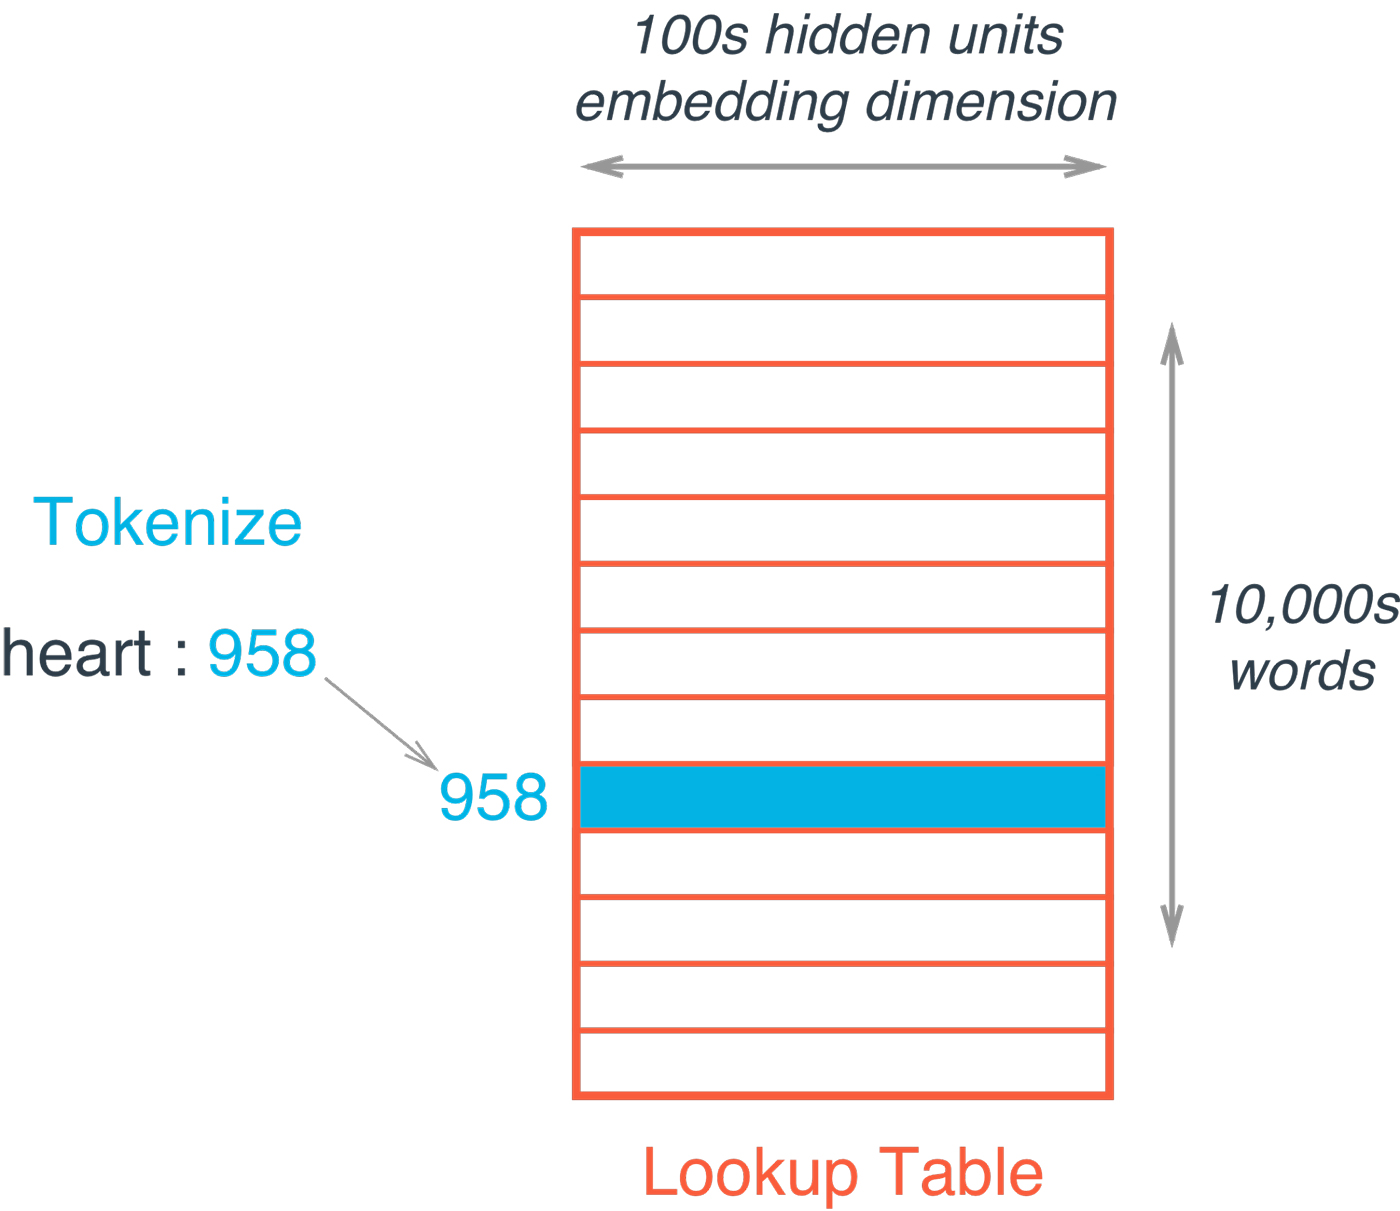

In [11]:
from IPython.display import Image
Image("../Images/embedding.jpg", width=500)

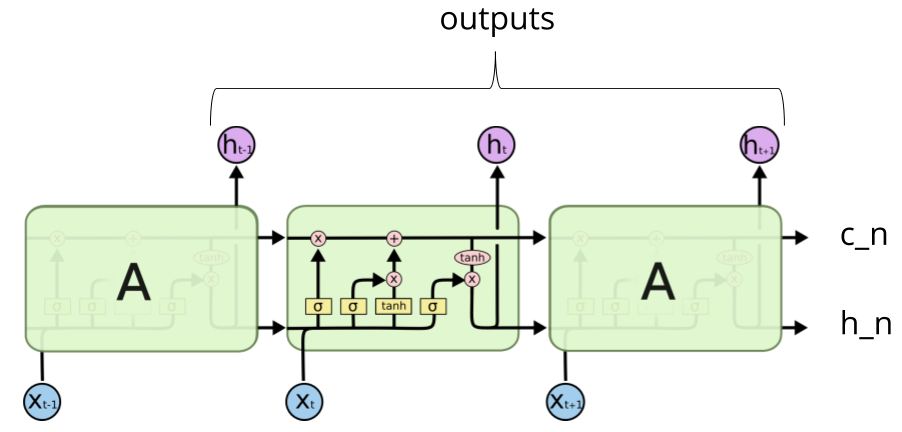

In [12]:
from IPython.display import Image
Image("../Images/LSTM_pytorch.png", width=1000)

#### Création du modèle

In [13]:
net = LSTMModele(embedding_dim = 50).to(device)

In [14]:
net

LSTMModele(
  (embeddings): Embedding(13246, 50)
  (lstm): LSTM(50, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

#### Définition de l'optimizer et de la loss

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

#### Boucle d'apprentissage

In [16]:
%%time
nb_epoch = 5
for epoch in range(nb_epoch):
    for batch in train_iter:
        data = batch.text.to(device)
        labels = batch.labels.to(device)
        
        outputs = net(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print ('epoch : ' + str(epoch))

print('Finished Training')

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
Finished Training
CPU times: user 42.3 s, sys: 1.73 s, total: 44.1 s
Wall time: 44.1 s


#### Mesure des performances

In [17]:
import numpy as np
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_iter:
        data = batch.text.to(device)
        labels = batch.labels.to(device)
        
        outputs = net(data)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(all_labels,all_preds)

0.8295517432208079

### Without PreTrained Word Embeddings

In [19]:
TEXT.build_vocab(train_dataset, min_freq=2)

In [20]:
class LSTMModeleNoEmbeddings(nn.Module):
    def __init__(self, embedding_dim=50):
        super(LSTMModele, self).__init__()

        self.embeddings = nn.Embedding(len(TEXT.vocab), embedding_dim = embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim,2)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        outputs, (h_n,c_n) = self.lstm(embeds)
        x = h_n[0]
        x = self.fc(x)
        return x

### Tensorboard

In [ ]:
net = LSTMModele(embedding_dim = 50).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('summary/lstm')

In [ ]:
%%time
nb_epoch = 20
for epoch in range(nb_epoch):
    for batch in train_iter:
        data = batch.text.to(device)
        labels = batch.labels.to(device)
        
        outputs = net(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Mesure des performances
    all_losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in test_iter:
            data = batch.text.to(device)
            labels = batch.labels.to(device)
        
            outputs = net(data)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.item())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(all_labels,all_preds)
    writer.add_scalars('Loss',  {'validation' : np.array(all_losses).mean()}, epoch)
    writer.add_scalars('Accuracy', {'validation' : accuracy}, epoch)
    
    all_losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in train_iter:
            data = batch.text.to(device)
            labels = batch.labels.to(device)
        
            outputs = net(data)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.item())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(all_labels,all_preds)
    writer.add_scalars('Loss',  {'train' : np.array(all_losses).mean()}, epoch)
    writer.add_scalars('Accuracy', {'train' : accuracy}, epoch)

In [ ]:
import numpy as np
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_iter:
        data = batch.text.to(device)
        labels = batch.labels.to(device)
        
        outputs = net(data)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(all_labels,all_preds)